In [ ]:
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Config option `use_jedi` not recognized by `IPCompleter`.



In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sn
from tqdm.notebook import tqdm
 
from functools import partial
from collections import OrderedDict

In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=9253e07efdf85c0575082e49125284d2510c372eb8803d4dcd9b1899be58f11b
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [ ]:
from torchviz import make_dot

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print(torch.__version__)

1.8.1+cu101


Files already downloaded and verified
Files already downloaded and verified


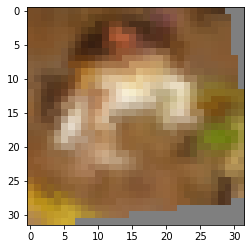

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ]
)

if True:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.GaussianBlur(kernel_size=[3,3], sigma=(0.2, 1)),
        transforms.RandomAffine(degrees=[-20, 20], translate=[0.1, 0.1], scale=[0.9, 1.1], shear=[-20, 20]),
        ])
    
 
trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True, num_workers=2)
 
testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(trainset[0][0])

In [ ]:
classes[trainset[0][1]]

'frog'

In [ ]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
def test(net, dataloader, device='cuda:0'):
    net = net.to(device)
    conf_matrix = np.zeros((10, 10))
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred = net(X)
            pred_cls = pred.argmax(1)
            for j in range(len(pred_cls)):
                conf_matrix[y[j]][pred_cls[j]] += 1
    return conf_matrix

In [ ]:
def train(net, dataloader, optimizer, loss_func, epochs=100, device='cuda:0', scheduler=None):
    n = len(trainloader.dataset)
    net.to(device)
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in tqdm(range(epochs)):
        epoch_ok = 0
        
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = net(X)
            loss = loss_func(pred, y)
            
            train_loss[epoch] += loss.item()
            pred_cls = pred.argmax(1)
            epoch_ok += sum(pred_cls == y)
            
            loss.backward()
            optimizer.step()
        
        if scheduler: scheduler.step()
        
        conf_matrix = test(net, testloader)    
        test_acc[epoch] = np.diag(conf_matrix).sum() / np.sum(conf_matrix)
        train_acc[epoch] = epoch_ok / n
        
        print(f'Epoch {epoch}: train loss: {train_loss[epoch]:.4f}, train acc: {train_acc[epoch]:.3f}, '
              f'test acc: {test_acc[epoch]}')
    
    return  train_acc, test_acc, train_loss, test_loss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red, c_out : dict, res = False):
        super().__init__()

        self.resTF = res
        self.res = nn.Conv2d(c_in, c_out["1x1"]+c_out["3x3"]+c_out["5x5"]+c_out["max"], kernel_size=1)

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            nn.ReLU()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red, kernel_size=1),
            nn.BatchNorm2d(c_red),
            nn.ReLU(),
            nn.Conv2d(c_red, c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            nn.ReLU()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red, kernel_size=1),
            nn.BatchNorm2d(c_red),
            nn.ReLU(),
            nn.Conv2d(c_red, c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            nn.ReLU()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            nn.ReLU()
        )


    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)

        if self.resTF:
            residal = self.res(x)
            x_out += residal
        
        return x_out

class IcepNet01(nn.Module):
    def __init__(self, classes=10, simpnet_name='IncepNet02'):
        super(IcepNet01, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
 
        self.inception_net = self._make_layers()
 
        self.gap = nn.MaxPool2d(kernel_size=(32, 32))
 
        self.linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 10),
            nn.ReLU()
        )
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception_net(x)
        x = self.gap(x)
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
 
    def _make_layers(self):
 
        model = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(16),
            InceptionBlock(c_in=16, c_red=16, c_out={"1x1":8, "3x3":8, "5x5":8, "max":8}),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            InceptionBlock(c_in=32, c_red=32, c_out={"1x1":16, "3x3":16, "5x5":16, "max":16}),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            InceptionBlock(c_in=64, c_red=64, c_out={"1x1":32, "3x3":32, "5x5":32, "max":32}),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            InceptionBlock(c_in=128, c_red=128, c_out={"1x1":32, "3x3":32, "5x5":32, "max":32}),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            InceptionBlock(c_in=128, c_red=128, c_out={"1x1":32, "3x3":32, "5x5":32, "max":32}),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
 
        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
 
        return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_func = nn.CrossEntropyLoss()
net = IcepNet01().to(device)
sgd = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(sgd, step_size=10, gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
train_acc, test_acc, train_loss, test_loss = train(net, trainloader, sgd, loss_func, 100)

Epoch 0: train loss: 3185.1290, train acc: 0.227, test acc: 0.3079
Epoch 1: train loss: 2681.0022, train acc: 0.349, test acc: 0.4038
Epoch 2: train loss: 2417.7579, train acc: 0.426, test acc: 0.4554
Epoch 3: train loss: 2280.4281, train acc: 0.468, test acc: 0.4817
Epoch 4: train loss: 2167.9812, train acc: 0.497, test acc: 0.5012
Epoch 5: train loss: 2080.3963, train acc: 0.522, test acc: 0.538
Epoch 6: train loss: 2005.5272, train acc: 0.542, test acc: 0.5478
Epoch 7: train loss: 1924.5003, train acc: 0.561, test acc: 0.5568
Epoch 8: train loss: 1869.5581, train acc: 0.578, test acc: 0.5781
Epoch 9: train loss: 1805.7647, train acc: 0.592, test acc: 0.5658
Epoch 10: train loss: 1759.3927, train acc: 0.604, test acc: 0.6014
Epoch 11: train loss: 1718.5789, train acc: 0.618, test acc: 0.6024
Epoch 12: train loss: 1673.4364, train acc: 0.626, test acc: 0.612
Epoch 13: train loss: 1634.4021, train acc: 0.636, test acc: 0.634
Epoch 14: train loss: 1601.3304, train acc: 0.643, test acc: 

In [ ]:
import pandas as pd
dataset = pd.DataFrame({'train_acc': train_acc, 
                        'test_acc': test_acc,
                        'train_loss': train_loss, 
                        'test_loss': test_loss})
dataset.to_csv('incepion_dense.csv')

# Specify a path
PATH = "Inception_dense.pt"

# Save
torch.save(net, PATH)

In [ ]:
from google.colab import files
files.download('incepion_dense.csv')
files.download('Inception_dense.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

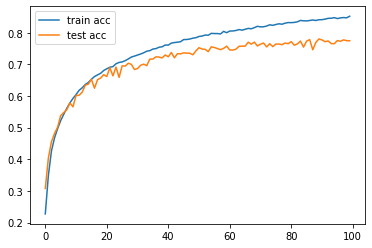

In [ ]:
plt.plot(train_acc,label='train acc')
plt.plot(test_acc,label='test acc')
plt.legend()
plt.show()

In [ ]:
train_acc_res, test_acc_res, train_loss_res, test_loss_res = train(resnet, trainloader, sgd, loss_func, 10)

Epoch 0: train loss: 596.9078, train acc: 0.872, test acc: 0.8084
Epoch 1: train loss: 602.0539, train acc: 0.873, test acc: 0.8055
Epoch 2: train loss: 593.2748, train acc: 0.871, test acc: 0.7979
Epoch 3: train loss: 590.3426, train acc: 0.872, test acc: 0.7997
Epoch 4: train loss: 580.9173, train acc: 0.874, test acc: 0.808
Epoch 5: train loss: 591.7177, train acc: 0.873, test acc: 0.8088
Epoch 6: train loss: 575.1690, train acc: 0.875, test acc: 0.803
Epoch 7: train loss: 577.0605, train acc: 0.876, test acc: 0.8049
Epoch 8: train loss: 576.3891, train acc: 0.876, test acc: 0.8078
Epoch 9: train loss: 565.6397, train acc: 0.879, test acc: 0.8036



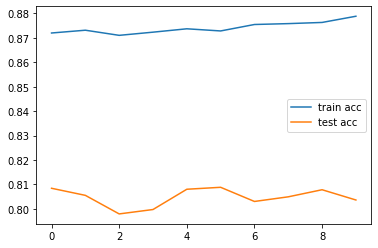

In [ ]:
plt.plot(train_acc_res,label='train acc')
plt.plot(test_acc_res,label='test acc')
plt.legend()
plt.show()